Build ML model

Goal: predict game result (win or lose) based on shot positions

Step 1. predict made_shot% based on shot position (classification), then use the made% to input to step 2

Step 2. predict player's score based on made% (regression), using the prediction fron step 1 predict player score and transfer prediction to step 3

Step 3. predict team's score based on player's score (regression, requires a calculation of player's contribution to team's performance), based on the prediction of step 2 make team score predictation and transfer to step 4

Step 4. predict win or lose based on team's score (classification), based on predictions from both step 2 and step 3 make win/loss prediction

In [ ]:
import sqlite3
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_columns', 999)
import numpy as np
import matplotlib as ml
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

In [2]:
conn = sqlite3.connect('teams_game_log.db')

df_team = pd.read_sql_query('SELECT * FROM teamslog', conn)
df_team.tail()

,id,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
13805,13805,1610612747,0021900074,"NOV 01, 2019",LAL @ DAL,W,4.0,1.0,0.800,265,47,96,0.490,9,32,0.281,16,21,0.762,6,35,41,24,11,7,11,21,119
13806,13806,1610612747,0021900054,"OCT 29, 2019",LAL vs. MEM,W,3.0,1.0,0.750,240,40,86,0.465,7,26,0.269,33,39,0.846,10,44,54,25,9,8,18,19,120
13807,13807,1610612747,0021900040,"OCT 27, 2019",LAL vs. CHA,W,2.0,1.0,0.667,240,49,93,0.527,11,31,0.355,11,14,0.786,10,37,47,30,7,8,13,22,120
13808,13808,1610612747,0021900025,"OCT 25, 2019",LAL vs. UTA,W,1.0,1.0,0.500,240,34,86,0.395,8,26,0.308,19,24,0.792,11,31,42,19,14,9,14,21,95
13809,13809,1610612747,0021900002,"OCT 22, 2019",LAL @ LAC,L,0.0,1.0,0.000,240,37,85,0.435,13,33,0.394,15,21,0.714,9,32,41,20,4,7,14,24,102


In [3]:
conn = sqlite3.connect('players_game_log.db')

df_player = pd.read_sql_query('SELECT * FROM playerslog', conn)
df_player.head()

,id,SEASON_ID,Player_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,0,22013,203506,0021301227,"APR 16, 2014",ORL vs. IND,L,17,2,8,0.250,0,1,0.000,0,0,0.00,0,2,2,1,1,0,2,2,4,-7,1
1,1,22013,203506,0021301208,"APR 14, 2014",ORL @ CHI,L,23,3,8,0.375,1,3,0.333,3,4,0.75,0,3,3,4,1,0,3,1,10,3,1
2,2,22013,203506,0021301199,"APR 13, 2014",ORL @ BKN,L,26,5,8,0.625,3,3,1.000,1,2,0.50,0,2,2,1,2,0,6,2,14,-13,1
3,3,22013,203506,0021301176,"APR 11, 2014",ORL vs. WAS,L,16,3,5,0.600,0,0,0.000,0,0,0.00,0,2,2,1,2,0,3,5,6,-9,1
4,4,22013,203506,0021301163,"APR 09, 2014",ORL vs. BKN,W,19,4,8,0.500,0,2,0.000,1,4,0.25,0,3,3,6,1,0,3,0,9,14,1


In [4]:
df_combined = pd.merge(df_team, df_player, on='Game_ID')
df_combined.shape

(23846, 55)

In [5]:
df_combined = df_combined.drop_duplicates(subset=['Game_ID'])
df_combined.columns

Index(['id_x', 'Team_ID', 'Game_ID', 'GAME_DATE_x', 'MATCHUP_x', 'WL_x', 'W',
       'L', 'W_PCT', 'MIN_x', 'FGM_x', 'FGA_x', 'FG_PCT_x', 'FG3M_x', 'FG3A_x',
       'FG3_PCT_x', 'FTM_x', 'FTA_x', 'FT_PCT_x', 'OREB_x', 'DREB_x', 'REB_x',
       'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'PTS_x', 'id_y',
       'SEASON_ID', 'Player_ID', 'GAME_DATE_y', 'MATCHUP_y', 'WL_y', 'MIN_y',
       'FGM_y', 'FGA_y', 'FG_PCT_y', 'FG3M_y', 'FG3A_y', 'FG3_PCT_y', 'FTM_y',
       'FTA_y', 'FT_PCT_y', 'OREB_y', 'DREB_y', 'REB_y', 'AST_y', 'STL_y',
       'BLK_y', 'TOV_y', 'PF_y', 'PTS_y', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')

In [7]:
# Combined df
df = df_combined[['PTS_x', 'PTS_y', 'Game_ID', 'Player_ID', 'WL_x', 'PLUS_MINUS']]


In [8]:
df = df.rename(columns={'PTS_x': 'TEAM_PTS',
                   'WL_x': 'W_L', 'PTS_y': 'PLAYER_PTS',
                    'Player_ID': 'PLAYER_ID'})
df.head()

,TEAM_PTS,PLAYER_PTS,Game_ID,PLAYER_ID,W_L,PLUS_MINUS
0,86,4,0021301227,203506,L,-7
2,95,10,0021301208,203506,L,3
6,88,14,0021301199,203506,L,-13
7,86,6,0021301176,203506,L,-9
8,115,9,0021301163,203506,W,14


In [9]:
# Created df to get_dummies for y
df_W_L = df['W_L']
df_W_L = pd.get_dummies(df_W_L)
df_W_L.drop('L', axis=1, inplace=True)

In [10]:
df_W_L.head()

,W
0,0
2,0
6,0
7,0
8,1


In [11]:
# Combined df
df = pd.concat([df, df_W_L], axis=1)

In [12]:
df.head()

,TEAM_PTS,PLAYER_PTS,Game_ID,PLAYER_ID,W_L,PLUS_MINUS,W
0,86,4,0021301227,203506,L,-7,0
2,95,10,0021301208,203506,L,3,0
6,88,14,0021301199,203506,L,-13,0
7,86,6,0021301176,203506,L,-9,0
8,115,9,0021301163,203506,W,14,1


In [13]:
oladip_df = df.loc[df['PLAYER_ID']==203506]
towns_df = df.loc[df['PLAYER_ID']==1626157]
jokic_df = df.loc[df['PLAYER_ID']==203999]
irving_df = df.loc[df['PLAYER_ID']==202681]
horford_df = df.loc[df['PLAYER_ID']==201143]
lillard_df = df.loc[df['PLAYER_ID']==203081]
gobert_df = df.loc[df['PLAYER_ID']==203497]
green_df = df.loc[df['PLAYER_ID']==203110]
leonard_df = df.loc[df['PLAYER_ID']==202695]
george_df = df.loc[df['PLAYER_ID']==202331]
butler_df = df.loc[df['PLAYER_ID']==202710]
embiid_df = df.loc[df['PLAYER_ID']==203954]
paul_df = df.loc[df['PLAYER_ID']==101108]
westbrook_df = df.loc[df['PLAYER_ID']==201566]
antetokounmpo_df = df.loc[df['PLAYER_ID']==203507]
davis_df = df.loc[df['PLAYER_ID']==203076]
harden_df = df.loc[df['PLAYER_ID']==201935]
curry_df = df.loc[df['PLAYER_ID']==201939]
durant_df = df.loc[df['PLAYER_ID']==201142]
james_df = df.loc[df['PLAYER_ID']==2544]

In [14]:
col_id= ['PLAYER_ID', 'Game_ID', 'W_L']
oladip_df.drop(col_id, axis=1, inplace=True)
towns_df.drop(col_id, axis=1, inplace=True)
jokic_df.drop(col_id, axis=1, inplace=True)
irving_df.drop(col_id, axis=1, inplace=True)
horford_df.drop(col_id, axis=1, inplace=True)
lillard_df.drop(col_id, axis=1, inplace=True)
gobert_df.drop(col_id, axis=1, inplace=True)
green_df.drop(col_id, axis=1, inplace=True)
leonard_df.drop(col_id, axis=1, inplace=True)
george_df.drop(col_id, axis=1, inplace=True)
butler_df.drop(col_id, axis=1, inplace=True)
embiid_df.drop(col_id, axis=1, inplace=True)
paul_df.drop(col_id, axis=1, inplace=True)
westbrook_df.drop(col_id, axis=1, inplace=True)
antetokounmpo_df.drop(col_id, axis=1, inplace=True)
davis_df.drop(col_id, axis=1, inplace=True)
harden_df.drop(col_id, axis=1, inplace=True)
curry_df.drop(col_id, axis=1, inplace=True)
durant_df.drop(col_id, axis=1, inplace=True)
james_df.drop(col_id, axis=1, inplace=True)

C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
oladip_df.head()

,TEAM_PTS,PLAYER_PTS,PLUS_MINUS,W
0,86,4,-7,0
2,95,10,3,0
6,88,14,-13,0
7,86,6,-9,0
8,115,9,14,1


In [16]:
# oladip_df.to_pickle("DataFrame/oladip_df")
# towns_df.to_pickle("DataFrame/towns_df")
# jokic_df.to_pickle("DataFrame/jokic_df")
# irving_df.to_pickle("DataFrame/irving_df")
# horford_df.to_pickle("DataFrame/horford_df")
# lillard_df.to_pickle("DataFrame/lillard_df")
# gobert_df.to_pickle("DataFrame/gobert_df")
# green_df.to_pickle("DataFrame/green_df")
# leonard_df.to_pickle("DataFrame/leonard_df")
# george_df.to_pickle("DataFrame/george_df")
# butler_df.to_pickle("DataFrame/butler_df")
# embiid_df.to_pickle("DataFrame/embiid_df")
# paul_df.to_pickle("DataFrame/paul_df")
# westbrook_df.to_pickle("DataFrame/westbrook_df")
# antetokounmpo_df.to_pickle("DataFrame/antetokounmpo_df")
# davis_df.to_pickle("DataFrame/davis_df")
# harden_df.to_pickle("DataFrame/harden_df")
# curry_df.to_pickle("DataFrame/curry_df")
# durant_df.to_pickle("DataFrame/durant_df")
# james_df.to_pickle("DataFrame/james_df")

1. train_test_split to split data into 80/20

2. cross_val_score to estimate the score on new data

3. preprocessing for standard scaler to transform data so that mean value is 0 and std is 1

4. Random_Forest_Classifier: A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

5. Decision Tree Classifier: Decision tree builds classification or regression models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed.

6. LinearSVC: Support Vector Classifier) is to fit to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data.

7. Logistic Regression: a statistical method for analyzing a dataset in which there are one or more independent variables that determine an outcome. 

8. Voting Classifier:  a wrapper for set of different ones that are trained and valuated in parallel in order to exploit the different peculiarities of each algorithm

9. Confusion matrix and accuracy score to see precision and recall

10. Joblib to save the model

In [533]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [18]:
from sklearn.externals import joblib

C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [19]:
# oladip_df.to_pickle("DataFrame/oladip_df")
# towns_df.to_pickle("DataFrame/towns_df")
# jokic_df.to_pickle("DataFrame/jokic_df")
# irving_df.to_pickle("DataFrame/irving_df")
# horford_df.to_pickle("DataFrame/horford_df")
# lillard_df.to_pickle("DataFrame/lillard_df")
# gobert_df.to_pickle("DataFrame/gobert_df")
# green_df.to_pickle("DataFrame/green_df")
# leonard_df.to_pickle("DataFrame/leonard_df")
# george_df.to_pickle("DataFrame/george_df")
# butler_df.to_pickle("DataFrame/butler_df")
# embiid_df.to_pickle("DataFrame/embiid_df")
# paul_df.to_pickle("DataFrame/paul_df")
# westbrook_df.to_pickle("DataFrame/westbrook_df")
# antetokounmpo_df.to_pickle("DataFrame/antetokounmpo_df")
# davis_df.to_pickle("DataFrame/davis_df")
# harden_df.to_pickle("DataFrame/harden_df")
# curry_df.to_pickle("DataFrame/curry_df")
# durant_df.to_pickle("DataFrame/durant_df")
# james_df.to_pickle("DataFrame/james_df")

In [508]:

y = np.array(james_df['W']).astype(int)
X = james_df.drop('W', 1)

df = (X.mean(axis=0), X.std(axis=0))
df = pd.DataFrame(list(df))
df = df.rename(index={0: 'X mean',
               1: 'X std'})
df = df.rename(columns={0: 'TEAM_PTS',
                        1: 'PLAYER_PTS',
                       2: 'PLUS_MINUS'})
print(df)
LeBronJames_win_stat = df
LeBronJames_win_stat.to_pickle("win_stat/LeBronJames_win_stat")

          TEAM_PTS  PLAYER_PTS  PLUS_MINUS
X mean  100.376471   27.515294    5.044706
X std    12.051789    8.196663   12.443810


In [509]:
#                0        1
# 0          VictorOladipo_win_stat   203506
# 1      Karl_AnthonyTowns_win_stat  1626157
# 2            NikolaJokic_win_stat   203999
# 3            KyrieIrving_win_stat   202681
# 4              AlHorford_win_stat   201143
# 5          DamianLillard_win_stat   203081
# 6             RudyGobert_win_stat   203497
# 7          DraymondGreen_win_stat   203110
# 8           KawhiLeonard_win_stat   202695
# 9             PaulGeorge_win_stat  202331
# 10           JimmyButler_win_stat   202710
# 11            JoelEmbiid_win_stat   203954
# 12             ChrisPaul_win_stat   101108
# 13      RussellWestbrook_win_stat  201566
# 14  GiannisAntetokounmpo_win_stat   203507
# 15          AnthonyDavis_win_stat  203076
# 16           JamesHarden_win_stat  201935
# 17          StephenCurry_win_stat   201939
# 18           KevinDurant_win_stat   201142
# 19           LeBronJames_win_stat     2544

In [510]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [511]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

In [512]:
X_train.shape


(680, 3)

In [513]:
# oladip_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/oladip_df_X")
# towns_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/towns_df_X")
# jokic_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/jokic_df_X")
# irving_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/irving_df_X")
# horford_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/horford_df")
# lillard_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/lillard_df_X")
# gobert_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/gobert_df_X")
# green_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/green_df_X")
# leonard_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/leonard_df_X")
# george_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/george_df_X")
# butler_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/butler_df_X")
# embiid_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/embiid_df")
# paul_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/paul_df")
# westbrook_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/westbrook_df")
# antetokounmpo_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/antetokounmpo_df_X")
# davis_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/davis_df_X")
# harden_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/harden_df_X")
# curry_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/curry_df_X")
# durant_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/durant_df_X")
# james_df_X = pd.DataFrame(X_train.columns).to_pickle("X_train_columns/james_df_X")

In [514]:
log_clf = LogisticRegression()
svm_clf = LinearSVC(random_state=42)
decision_tree_clf = DecisionTreeClassifier(random_state=42)
random_forest_clf = RandomForestClassifier(n_estimators=1000, random_state=42)


In [515]:
named_estimators = [
    ('Log_clf', log_clf),
    ('svm_clf', svm_clf),
    ('decision_tree', decision_tree_clf),
    ('random_forest_clf', random_forest_clf),
]

In [516]:
estimators = [log_clf, svm_clf, decision_tree_clf, random_forest_clf]
for estimator in estimators:
    print('Training the', estimator)
    estimator.fit(X_train, y_train)

Training the LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Training the LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)
Training the ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                     max_depth=None, max_features=3, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=1000,
                     n_jobs=None, oob_score=False, 

C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training the RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [517]:
voting_clf = VotingClassifier(named_estimators)


In [518]:
voting_clf.fit(X_train, y_train)

C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


VotingClassifier(estimators=[('Log_clf',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svm_clf',
                              LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True,...
                                                     class_weight=None,
                                 

In [519]:
voting_clf.estimators_

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
           verbose=0),
 ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                      max_depth=None, max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbo

In [520]:
voting_clf.score(X_test, y_test)

0.8470588235294118

In [521]:
estimator_score = [estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

In [522]:
estimator_df = pd.DataFrame(estimator_score)
idx_rename = {0:'log_clf', 1:'svm_clf', 2:'extra_tree', 3:'random_forest'}
col_rename = {0: 'accuracy_score'}

estimator_df = estimator_df.rename(index=idx_rename, columns=col_rename)
estimator_df

,accuracy_score
log_clf,0.864706
svm_clf,0.870588
extra_tree,0.794118
random_forest,0.841176


In [494]:
voting_scores = cross_val_score(voting_clf, X_test, y_test, cv=3, scoring='accuracy')
voting_scores.mean()

C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7777777777777778

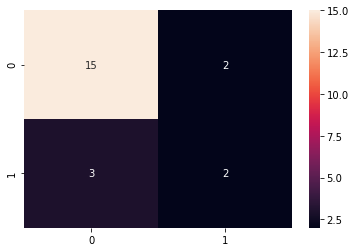

In [495]:
voting_clf_pred = voting_clf.predict(X_test)
matrix_log = confusion_matrix(y_test, voting_clf_pred)
sn.heatmap(matrix_log, annot=True)

In [523]:
log_scores = cross_val_score(log_clf, X_test, y_test, cv=3, scoring='accuracy')
log_scores.mean()

C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ktung\Anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8648705096073517

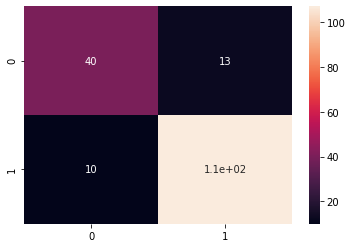

In [524]:
log_clf_pred = log_clf.predict(X_test)
matrix_log = confusion_matrix(y_test, log_clf_pred)
sn.heatmap(matrix_log, annot=True)

In [525]:
svm_clf_pred = svm_clf.predict(X_test)

In [526]:
svm_scores = cross_val_score(svm_clf, X_test, y_test, cv=3, scoring='accuracy')
svm_scores.mean()

0.870718462823726

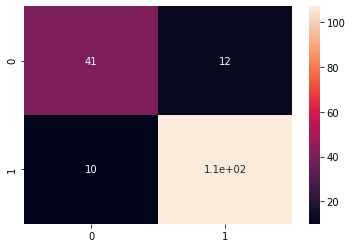

In [527]:
matrix_svm = confusion_matrix(y_test, svm_clf_pred)
sn.heatmap(matrix_svm, annot=True)

In [109]:
feature_importance = decision_tree_clf.feature_importances_
# feature_importance = pd.DataFrame(np.std([tree.feature_importances_ for tree in extra_trees_clf.estimators_], axis=0)).reset_index()
# feature_importance = feature_importance.rename(columns={0: 'Feature'})
sorted(zip(feature_importance, X_train), reverse=True)
# feature_importance.sort_values('Feature', ascending=False)

[(0.43526678509738387, array([ 0.92438544, -0.15387715,  0.92898613])),
 (0.3512831496992661, array([-0.901721  , -0.86060936, -1.47368577])),
 (0.21345006520335008, array([-1.20607207,  0.19948895, -1.88793955]))]

In [103]:

# # Plotting a Bar Graph to compare the models 
# plt.bar(X.columns, feature_importance[:5]) 
# plt.xlabel('Feature Labels') 
# plt.ylabel('Feature Importances') 
# plt.title('Comparison of different Feature Importances') 
# plt.show()

In [110]:
decision_tree_scores = cross_val_score(decision_tree_clf, X_test, y_test, cv=3, scoring='accuracy')
decision_tree_scores.mean()

0.6771929824561402

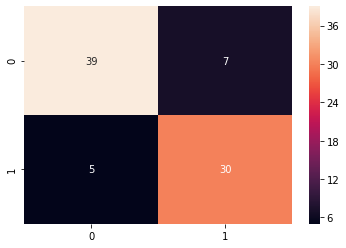

In [57]:
decision_tree_clf_pred = decision_tree_clf.predict(X_test)
matrix_extra = confusion_matrix(y_test, decision_tree_clf_pred)
sn.heatmap(matrix_extra, annot=True)

In [501]:
forest_scores = cross_val_score(random_forest_clf, X_test, y_test, cv=3, scoring='accuracy')
forest_scores.mean()

0.7777777777777778

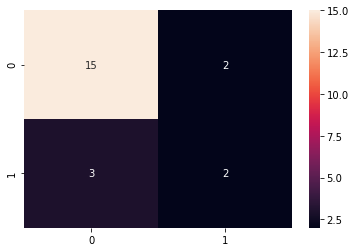

In [502]:
random_forest_clf_pred = random_forest_clf.predict(X_test)
matrix_forest = confusion_matrix(y_test, random_forest_clf_pred)
sn.heatmap(matrix_forest, annot=True)


In [64]:
feature_importance = random_forest_clf.feature_importances_
sorted(zip(feature_importance, X_train), reverse=True)

AttributeError: 'numpy.ndarray' object has no attribute 'Columns'

In [109]:
# sfm = SelectFromModel(random_forest_clf, threshold=.015)
# sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=1000, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=42, verbose=0,
   

In [110]:
# for feature_list_index in sfm.get_support(indices=True):
#     print(X_train.columns[feature_list_index])

SHOT_DISTANCE
angle
ACTION_TYPE_Jump Shot


In [112]:
# X_important_train = sfm.transform(X_train)
# X_important_test = sfm.transform(X_test)

In [113]:
# clf_important = RandomForestClassifier(n_estimators=1000, random_state=42)
# clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [114]:
# y_important_pred = clf_important.predict(X_important_test)
# accuracy_score(y_test, y_important_pred)

0.5655105973025049

In [528]:
filename = 'LeBronJames_w_l.model'

In [529]:
# joblib.dump(log_clf, filename)
joblib.dump(svm_clf, filename)
# joblib.dump(extra_trees_clf, filename)
# joblib.dump(random_forest_clf, filename)
# joblib.dump(voting_clf, filename)

['LeBronJames_w_l.model']

In [530]:
loaded_model = joblib.load('LeBronJames_w_l.model')

In [531]:
result = loaded_model.score(X_test, y_test)

In [532]:
print(result)

0.8705882352941177


In [ ]:
#                0        1
# 0          VictorOladipo_w_l   203506
# 1      Karl_AnthonyTowns_w_l  1626157
# 2            NikolaJokic_w_l   203999
# 3            KyrieIrving_w_l   202681
# 4              AlHorford_w_l   201143
# 5          DamianLillard_w_l   203081
# 6             RudyGobert_w_l   203497
# 7          DraymondGreen_w_l   203110
# 8           KawhiLeonard_w_l   202695
# 9             PaulGeorge_w_l   202331
# 10           JimmyButler_w_l   202710
# 11            JoelEmbiid_w_l   203954
# 12             ChrisPaul_w_l   101108
# 13      RussellWestbrook_w_l   201566
# 14  GiannisAntetokounmpo_w_l   203507
# 15          AnthonyDavis_w_l   203076
# 16           JamesHarden_w_l   201935
# 17          StephenCurry_w_l   201939
# 18           KevinDurant_w_l   201142
# 19           LeBronJames_w_l     2544